In [2]:
!pip install psycopg2

  Using cached psycopg2-2.7.4-cp36-cp36m-manylinux1_x86_64.whl


In [3]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
from matplotlib import pyplot as plt

/home/bill/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
conn = psycopg2.connect(dbname="local_density", user="adi", password="password")

In [5]:
SELECT = """
    SELECT d.client_count, d.dump_time,
           r.id AS group_id, r.name AS group_name,
           b.id AS parent_id, b.name AS building_name
    FROM density_data d
    JOIN routers r ON r.id = d.group_id
    JOIN buildings b ON b.id = r.building_id"""

In [6]:
def db_to_pandas(conn):
    """ Return occupancy data as pandas dataframe
    column dtypes:
        group_id: int64
        group_name: category
        parent_id: int64
        parent_name: category
        client_count: int64
        week: int64
        weekday: int64
        time_point: string
    index: DateTimeIndex -- dump_time
    Parameters
    ----------
    conn: psycopg2.extensions.connection
        Connection to db
    Returns
    -------
    pandas.DataFrame
        Density data in a Dataframe
    """

    df = pd.read_sql(SELECT, conn) \
           .set_index("dump_time") \
           .assign(group_name=lambda df: df["group_name"].astype('category'),
                   parent_id=lambda df: df["parent_id"].astype('category'))
    df['week'] = df.index.weekofyear  # get week of the year (1-52) for a given timestamp
    df['weekday'] = df.index.weekday  # get day of the week (1-7) for a given timestamp
    time_points = zip(df.index.hour, df.index.minute)
    time_points = ["{}:{}".format(x[0], x[1]) for x in time_points]
    df["time_point"] = time_points # get time of the day (HH:mm) for a given timestamp
    
    return df


In [7]:
def parse_by_week(df):
    """Return a dictionary of dataframes where the keys are days of the week
    Parameters
    ----------
    df: pandas.DataFrame
        Density data in a Dataframe
    Returns
    -------
    Dictionary
        a dictionary of dataframes where the keys are days of the week
    """
    weeks = np.unique(df['week'])
    week_dic = dict.fromkeys(weeks)
    
    for week in weeks:
        week_dic[week] = df[df['week'] == week]
    
    return week_dic

In [8]:
def predict_tomorrow(day_dict):
    """Return a dataframes of predicted counts for tomorrow 
    where the indexs are timestamps of the week and columns are locations
    Parameters
    ----------
    day_dict: Dictionary
        a dictionary of dataframes of density data where the keys are days of the week
    Returns
    -------
    pandas.DataFrame
        Dataframe containing predicted counts
    """
    # get time stats for tomorrow
    tomorrow = datetime.datetime.today() + datetime.timedelta(days=1)
    day_of_week = tomorrow.weekday()
    week_of_year = tomorrow.isocalendar()[1]
    
    # find past data for the given day of the week
    past_data = day_dict[week_of_year]
    past_data = past_data[past_data['weekday'] == day_of_week]
    
    results, locs = [], []
    for group in np.unique(past_data["group_name"]):
        locs.append(group)
        group_data = past_data[past_data["group_name"] == group]
        group_data = group_data[["client_count", "time_point"]]
        group_result = group_data.groupby("time_point").mean()  # average counts by time for each location
        results.append(group_result.transpose())
    result = pd.concat(results)  # combine the data for all locations
    result.index = locs
    result = result.transpose()  # make time points indexes and locations columns
    
    old_indexes = result.index
    new_indexes = []

    # make sure all time index has the same string format
    for index in old_indexes:
        splited = index.split(":")
        leading, trailing = splited[0], splited[1]
        if len(leading) == 1:
            leading = "0" + leading
        new_index = leading + ":" + trailing
        new_indexes.append(new_index)

    result.index = new_indexes
    result = result.sort_index()
    
    return result

In [9]:
data = db_to_pandas(conn)

In [10]:
data.columns

Index(['client_count', 'group_id', 'group_name', 'parent_id', 'building_name',
       'week', 'weekday', 'time_point'],
      dtype='object')

In [11]:
by_week = parse_by_week(data)

In [12]:
tp = predict_tomorrow(by_week)

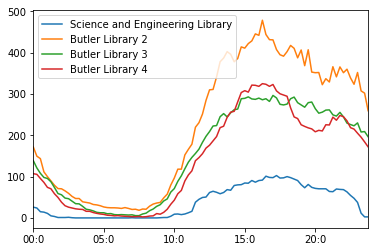

In [13]:
tmp = tp[['Science and Engineering Library', 'Butler Library 2', 'Butler Library 3', 'Butler Library 4']]
tmp.plot()
plt.show()

In [14]:
type(tp)

pandas.core.frame.DataFrame

In [17]:
tp.keys()

Index(['Architectural and Fine Arts Library 1',
       'Architectural and Fine Arts Library 2',
       'Architectural and Fine Arts Library 3', 'Butler Library 2',
       'Butler Library 3', 'Butler Library 301', 'Butler Library 4',
       'Butler Library 5', 'Butler Library 6', 'Butler Library stk',
       'JJ's Place', 'John Jay Dining Hall', 'Lehman Library 2',
       'Lehman Library 3', 'Lerner 1', 'Lerner 2', 'Lerner 3', 'Lerner 4',
       'Lerner 5', 'Roone Arledge Auditorium',
       'Science and Engineering Library', 'Starr East Asian Library',
       'Uris/Watson Library'],
      dtype='object')

In [21]:
a = tp[['Architectural and Fine Arts Library 1']]

In [27]:
a.shape

(96, 1)

In [28]:
list(a.index)

['00:0',
 '00:15',
 '00:30',
 '00:45',
 '01:0',
 '01:15',
 '01:30',
 '01:45',
 '02:0',
 '02:15',
 '02:30',
 '02:45',
 '03:0',
 '03:15',
 '03:30',
 '03:45',
 '04:0',
 '04:15',
 '04:30',
 '04:45',
 '05:0',
 '05:15',
 '05:30',
 '05:45',
 '06:0',
 '06:15',
 '06:30',
 '06:45',
 '07:0',
 '07:15',
 '07:30',
 '07:45',
 '08:0',
 '08:15',
 '08:30',
 '08:45',
 '09:0',
 '09:15',
 '09:30',
 '09:45',
 '10:0',
 '10:15',
 '10:30',
 '10:45',
 '11:0',
 '11:15',
 '11:30',
 '11:45',
 '12:0',
 '12:15',
 '12:30',
 '12:45',
 '13:0',
 '13:15',
 '13:30',
 '13:45',
 '14:0',
 '14:15',
 '14:30',
 '14:45',
 '15:0',
 '15:15',
 '15:30',
 '15:45',
 '16:0',
 '16:15',
 '16:30',
 '16:45',
 '17:0',
 '17:15',
 '17:30',
 '17:45',
 '18:0',
 '18:15',
 '18:30',
 '18:45',
 '19:0',
 '19:15',
 '19:30',
 '19:45',
 '20:0',
 '20:15',
 '20:30',
 '20:45',
 '21:0',
 '21:15',
 '21:30',
 '21:45',
 '22:0',
 '22:15',
 '22:30',
 '22:45',
 '23:0',
 '23:15',
 '23:30',
 '23:45']

In [29]:
tp

,Architectural and Fine Arts Library 1,Architectural and Fine Arts Library 2,Architectural and Fine Arts Library 3,Butler Library 2,Butler Library 3,Butler Library 301,Butler Library 4,Butler Library 5,Butler Library 6,Butler Library stk,...,Lehman Library 3,Lerner 1,Lerner 2,Lerner 3,Lerner 4,Lerner 5,Roone Arledge Auditorium,Science and Engineering Library,Starr East Asian Library,Uris/Watson Library
00:0,1.0,7.5,0.5,171.5,138.5,140.0,107.0,11.0,4.5,23.5,...,3.5,67.5,42.5,26.0,17.5,112.5,12.0,26.0,9.5,3.5
00:15,1.0,8.0,1.0,149.5,121.0,135.0,105.5,7.0,5.5,20.0,...,4.0,63.0,39.0,22.5,10.5,107.0,5.5,24.0,9.0,4.0
00:30,1.0,8.5,1.0,143.5,108.0,119.0,95.5,9.0,6.0,18.0,...,3.5,50.5,48.0,26.5,17.0,102.0,12.5,15.0,4.0,2.5
00:45,1.0,8.5,1.0,111.5,98.0,109.0,86.0,9.5,4.5,16.0,...,4.0,15.0,38.0,15.5,12.0,96.5,9.5,14.0,3.5,2.5
01:0,0.5,9.0,1.0,100.0,95.5,113.0,74.0,8.0,4.5,15.5,...,3.5,7.0,35.5,19.0,13.5,89.0,7.0,11.0,1.5,2.5
01:15,0.5,8.0,0.5,89.5,87.5,106.0,70.5,11.0,4.5,14.5,...,3.0,5.0,26.5,17.5,12.5,58.5,6.5,5.0,2.0,2.0
01:30,0.5,7.5,0.5,79.0,73.5,92.0,58.5,7.5,5.0,13.0,...,3.0,2.0,26.0,11.5,10.0,30.5,7.0,3.5,3.5,2.0
01:45,0.5,7.5,0.5,71.0,59.0,74.0,49.5,9.0,4.0,12.5,...,2.5,1.5,26.0,15.0,8.5,26.0,4.0,1.0,4.5,1.5
02:0,0.5,7.0,0.5,70.5,56.0,74.0,38.0,10.5,4.0,11.5,...,2.5,2.0,24.0,13.0,9.5,20.5,4.0,1.0,3.0,1.5
02:15,0.5,7.0,1.0,65.5,48.0,63.0,29.5,8.5,2.0,10.5,...,2.5,1.5,23.5,10.5,8.5,17.5,4.0,1.0,2.5,1.5


In [31]:
for i in tp.index:
    tp[i]

KeyError: '00:0'

In [43]:
list(tp.loc['00:0'])

[1.0,
 7.5,
 0.5,
 171.5,
 138.5,
 140.0,
 107.0,
 11.0,
 4.5,
 23.5,
 12.5,
 90.0,
 4.0,
 3.5,
 67.5,
 42.5,
 26.0,
 17.5,
 112.5,
 12.0,
 26.0,
 9.5,
 3.5]